# State detection pipeline on motion energy 
Binarises motion into prospective Active/Awake and Rest/Sleep state & performs twitch detection during Rest

In [1]:
import os
# going to root directory (if not there yet)
current_dir = os.getcwd().split('/')[-1]
if current_dir != 'pixelNMF': 
    os.chdir('..')

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import tifffile
from skimage import filters
from scipy.ndimage import label, binary_closing

from pathlib import Path
from PIL import Image
import imageio
import cv2

from data_io import *
from analyse.videography_compute import *
from analyse.videography_plot import *

In [3]:
os.getcwd()

'C:\\Users\\zaggila\\Documents\\pixelNMF\\patchnmf'

In [4]:
# setting common plot params 
from matplotlib import rcParams

rcParams['figure.figsize'] = [20, 4]
rcParams['font.size'] = 15
rcParams['axes.spines.top'] = False
rcParams['axes.spines.right'] = False
rcParams['figure.autolayout'] = True

In [5]:
def mkdir(path):
    if not os.path.exists(path): os.makedirs(path)
    return path

In [6]:
data_path = rf'C:\Users\zaggila\Documents\pixelNMF\data'
sessions = sorted([f for f in os.listdir(data_path) if f.endswith('_cell_control')])
print(f'All sessions: {sessions}')

All sessions: ['sz89_2024-06-04_a_cell_control', 'sz89_2024-06-06_a_cell_control', 'sz89_2024-06-07_a_cell_control', 'sz90_2024-06-05_a_cell_control', 'sz90_2024-06-06_a_cell_control', 'sz90_2024-06-07_a_cell_control', 'sz91_2024-06-05_b_cell_control', 'sz92_2024-06-06_a_cell_control', 'sz92_2024-06-07_a_cell_control']


In [7]:
ds = 'sz90_2024-06-06_a_cell_control'

subject_path = os.path.join(data_path, ds) # choose one specifc ds 
movie_path = os.path.join(subject_path, 'cam_crop.tif')

#load sleap output
files = os.listdir(subject_path)
csv_files = [f for f in files if f.endswith('.csv')]

# Check if there is exactly one CSV file
if len(csv_files) == 1:
    # Load the CSV file into a DataFrame
    sleap_output_path = os.path.join(subject_path, csv_files[0])  # Get full path to the CSV file
    sleap_output = pd.read_csv(sleap_output_path)  # Pass the file path
    print(f"Loaded {csv_files[0]}")
else:
    if len(csv_files) == 0:
        raise FileNotFoundError("No CSV files found")
    else:
        raise FileExistsError("Multiple CSV files found. Please ensure there is only one CSV file in the subject directory.")

save_dir = subject_path
save_dir_videography = mkdir(f'{save_dir}/videography_processing')
save_dir_videography = Path(save_dir_videography)

Loaded sz090_2024-06-06_a.sleap.csv


# Set parameters 

In [8]:
gaussian_sigma = 3

# Thresholds for binarisation
threshold_binary = 'otsu'  # threshold for binary: a/r state detcetion -
threshold_twitch = 'li' #threshold for twitch detection (more permissive -> detect more/lose less)
# thresh_factor = 1.0  # used for "mean+std" option

# Twitch detection thresholds
framerate = 3  # Hz

active_motion_duration_min = framerate * 1 # 1 sec 
long_active_motion_duration_min = framerate * 3 # at least 3 seconds to be considered a long awake motion eg run 
twitch_duration_max = active_motion_duration_min
twitch_min_distance_from_active = framerate * 3  # at least 3 sec away from awake motion to be detected as twitch 
print(f' max_twitch_allowed: {twitch_duration_max/framerate} sec') 

 max_twitch_allowed: 1.0 sec


# Compute/Load motion energy

Motion energy already computed. Loading from C:\Users\zaggila\Documents\pixelNMF\data\sz90_2024-06-06_a_cell_control\motion_energy.npy


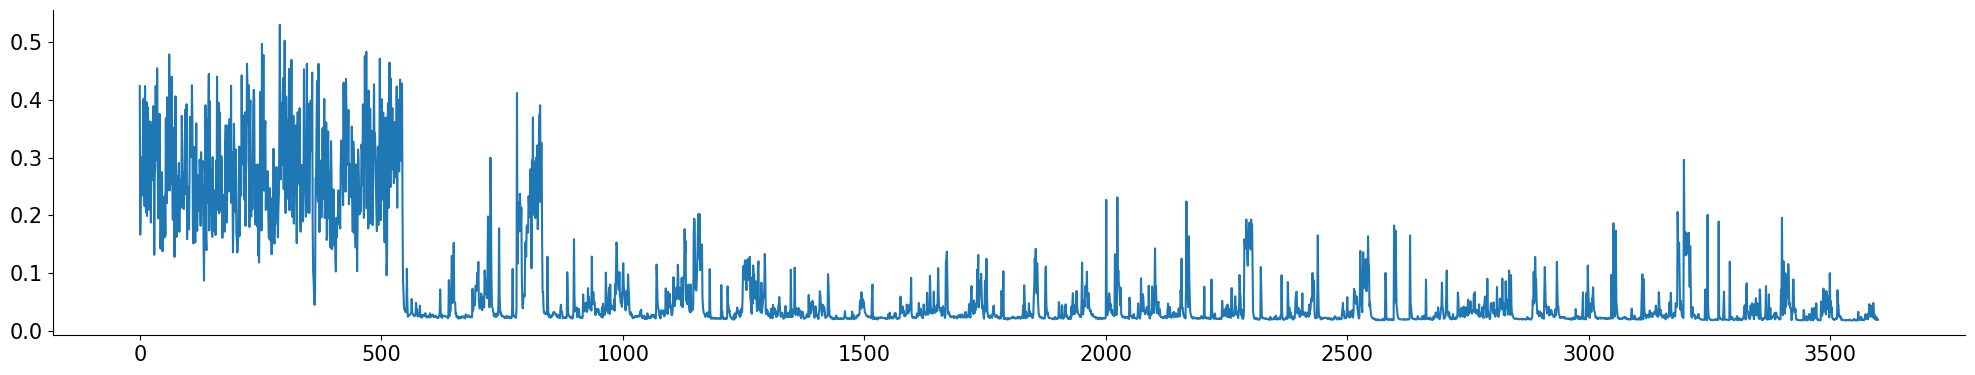

In [9]:
motion_energy = compute_motion_energy(movie_path=movie_path, xrange=None, yrange=None, save_path=subject_path) #if first run, provide movie_path

if len(motion_energy) != 3600:
    motion_energy = pad(motion_energy)
    motion_energy = average_frames(motion_energy, avg_block = 5)

plt.plot(motion_energy)
plt.show()

In [10]:
length_acts = len(motion_energy)
# for plotting xticks to seconds
frame_ticks = range(0, length_acts+ 100, 300)  # 300 frames is 100 sec
second_ticks = [int(tick/framerate) for tick in frame_ticks]   # Convert to seconds

# Smooth motion energy

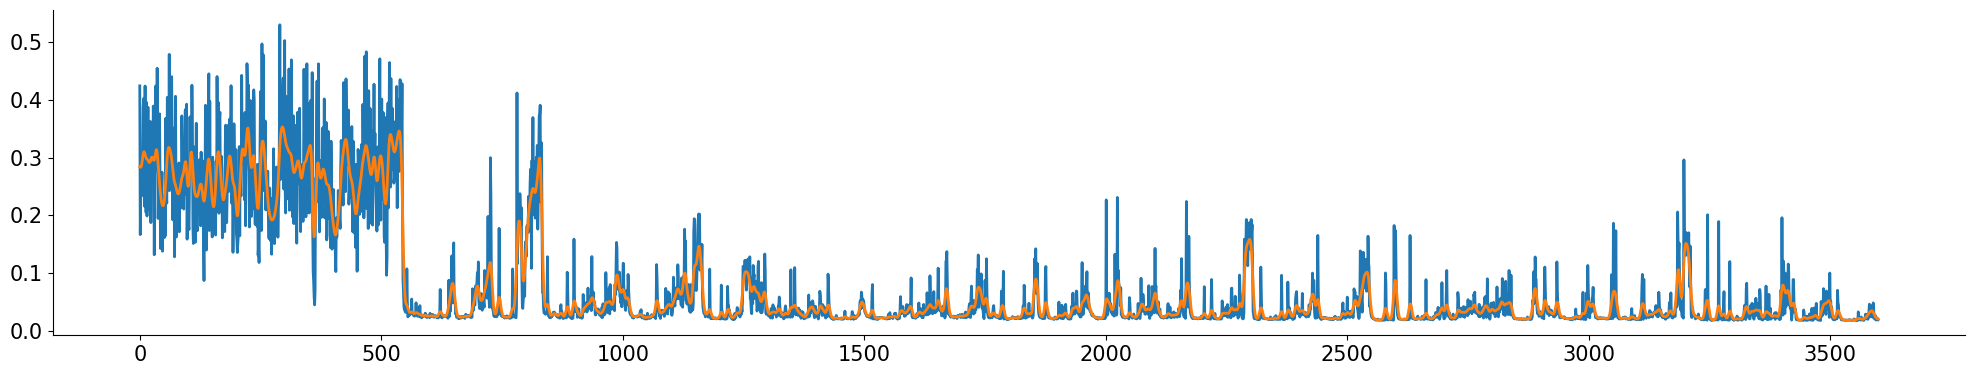

In [11]:
# Smooth motion energy
smoothed_motion_energy = smooth_with_gaussian(motion_energy, sigma=gaussian_sigma)

plt.plot(motion_energy, linewidth=2)
plt.plot(smoothed_motion_energy, linewidth=2)
plt.show()

In [12]:
# from scipy.signal import savgol_filter

# motion_energy_smooth_savgol = savgol_filter(motion_energy, window_length=10, polyorder=2)
# plt.plot(motion_energy)
# plt.plot(motion_energy_smooth_savgol, c='lime')
# plt.plot(smoothed_motion_energy, c='r')

# plt.show()

# Choose statistical threshold for binarisation 

In [13]:
def compute_thresholds_for_bin_state_detection(motion_signal, title='', save_dir=None, plot=True):
    '''
    Compute statistical thresholds to use for threshold-based state detection (active/awake - rest)
    Here we use: Otsu (prefer if binary distribution), Li (mutliple peak distribution), or mean+sd (gaussian distribution)
    '''
    
    # mean+sd threshold 
    motion_mean = np.mean(motion_signal)
    motion_sd = np.std(motion_signal)

    threshold_motion_mean_sd = motion_mean + motion_sd

    threshold_motion_li = filters.threshold_li(motion_signal)

    threshold_motion_otsu = filters.threshold_otsu(motion_signal)

    if plot:
        plt.figure(figsize=(5, 5), dpi=300)
        plt.title(f'{title}')
        plt.hist(motion_signal, bins=70, alpha=0.9)

        # mark threshold lines
        plt.axvline(x=threshold_motion_mean_sd, color='red', label='mean + sd', linestyle='--')
        plt.axvline(x=threshold_motion_otsu, color='salmon', label='Otsu', linestyle='--')
        plt.axvline(x=threshold_motion_li, color='darkred', label='Li', linestyle='--')

        plt.legend()
        plt.savefig(save_dir / f'{title}.png')
        plt.show()

    return threshold_motion_mean_sd, threshold_motion_li, threshold_motion_otsu

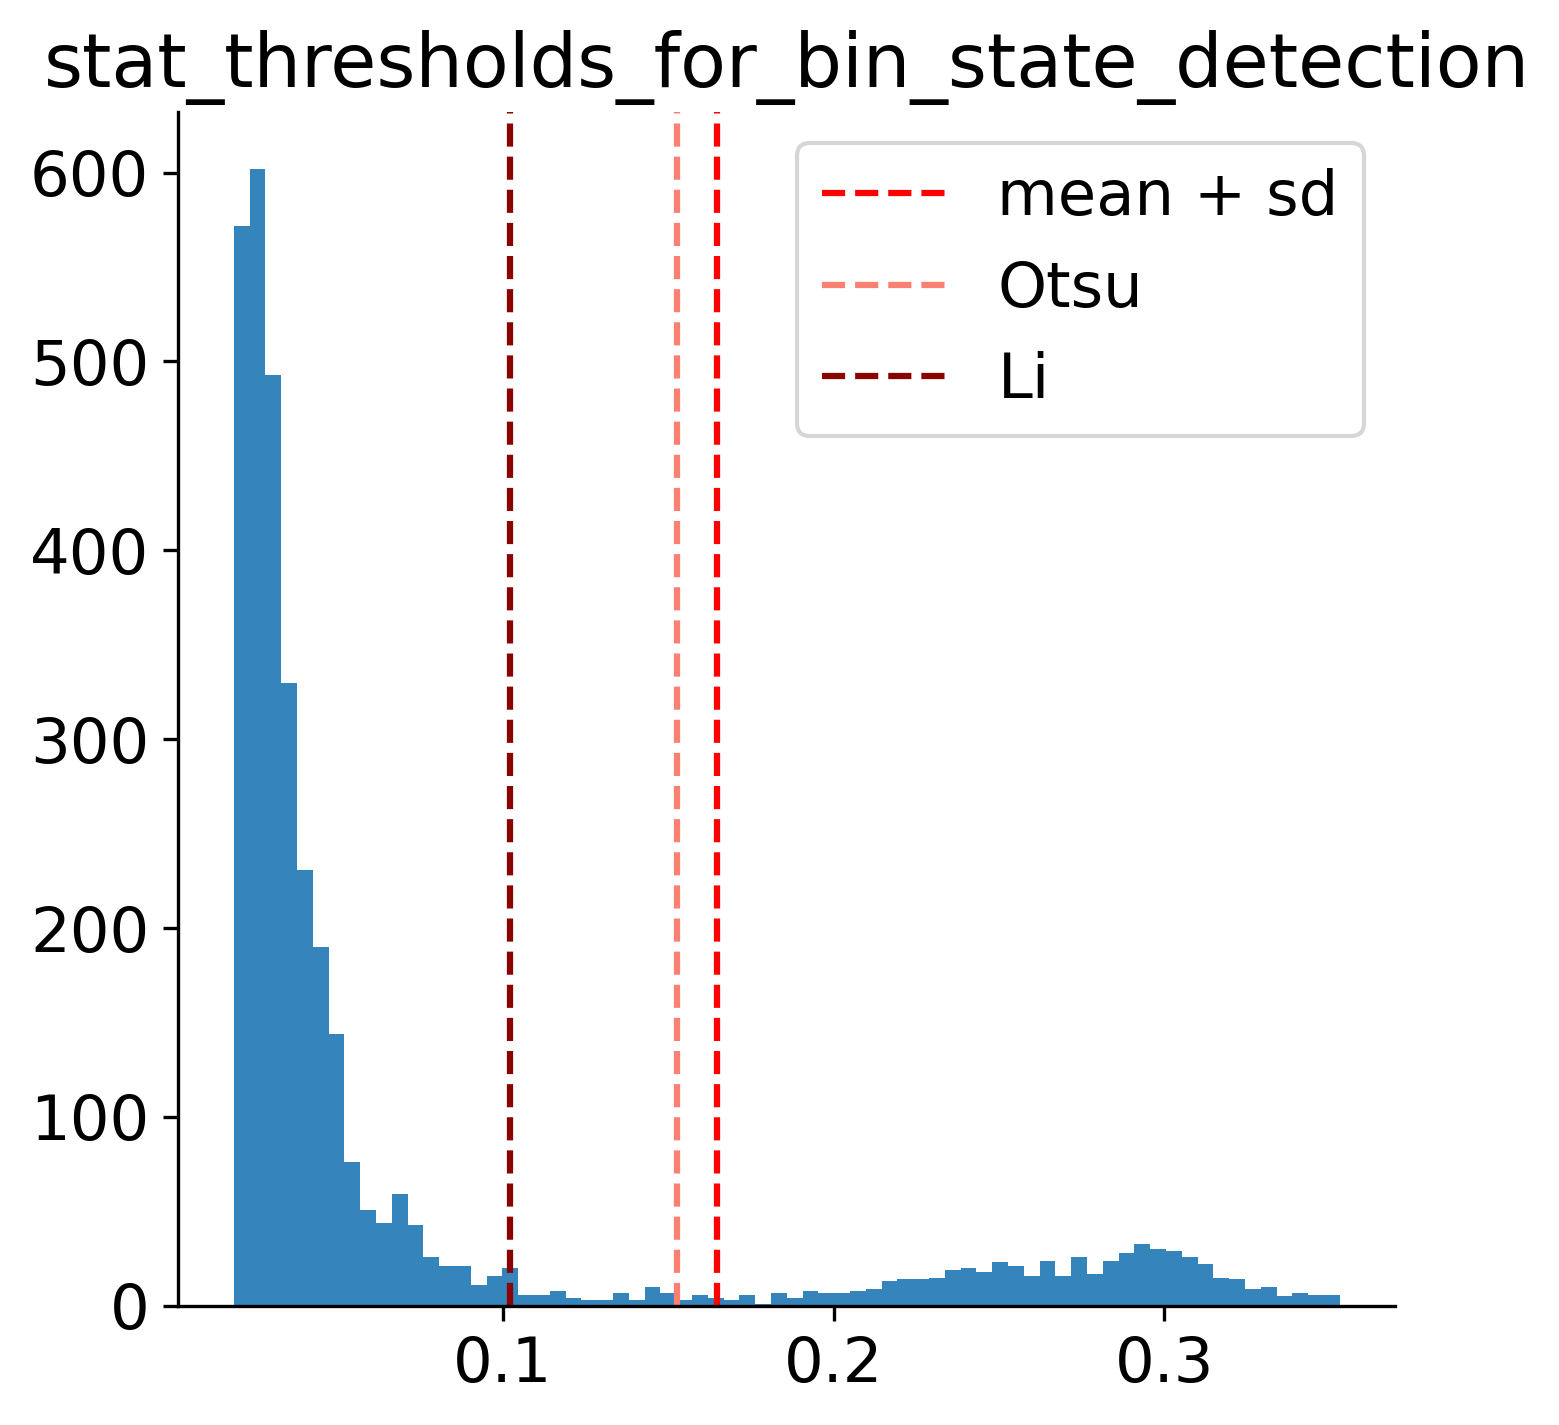

In [14]:
threshold_motion_mean_sd, threshold_motion_li, threshold_motion_otsu = compute_thresholds_for_bin_state_detection(smoothed_motion_energy, title='stat_thresholds_for_bin_state_detection', save_dir=save_dir_videography, plot=True)

# Choose binarisation threshold 

In [15]:
binary_threshold = threshold_motion_otsu

# Binarise motion energy

In [16]:
def binarise_motion(motion_signal, binary_threshold, min_duration, min_inactive_gap=9):
    '''
    Binarises motion signal (eg mot_en) into 0s (rest) and 1s (active)
    input params:
    motion_signal: motion energy or other
    binary_threshold: sts threshold (li, otsu or mean_sd for state detection)
    min_di=uration: min_duration threshold to be detected as awake/active motion
    
    returns:
    bin_motion_signal: bin array of 0s and 1s 
    inds_active_state: indices of frames whens state is active
    inds_rest_state: indices of frames when state is rest/inactive 

    '''
    
    bin_motion_signal = np.zeros(len(motion_signal), dtype=int)

    # get boolean array 
    
    all_active_motions_detected = motion_signal > binary_threshold 

    # labels continuous segments that pass the threshold 

    labeled_array, n_features = label(all_active_motions_detected) #how many active motions where found 
    
    for i in range(1, n_features+1):
        segment = np.where(labeled_array == i)[0]
        if len(segment) > min_duration:
            bin_motion_signal[segment] = 1

    inds_active_state = np.where(bin_motion_signal ==1)
    inds_rest_state = np.where(bin_motion_signal ==0)
    
    return bin_motion_signal, inds_active_state, inds_rest_state

In [17]:
bin_motion_energy, inds_active_state, inds_rest_state =  binarise_motion(smoothed_motion_energy, binary_threshold=binary_threshold, min_duration=active_motion_duration_min, min_inactive_gap=9)

# Plot binary motion (Active - 1 / Rest - 0)

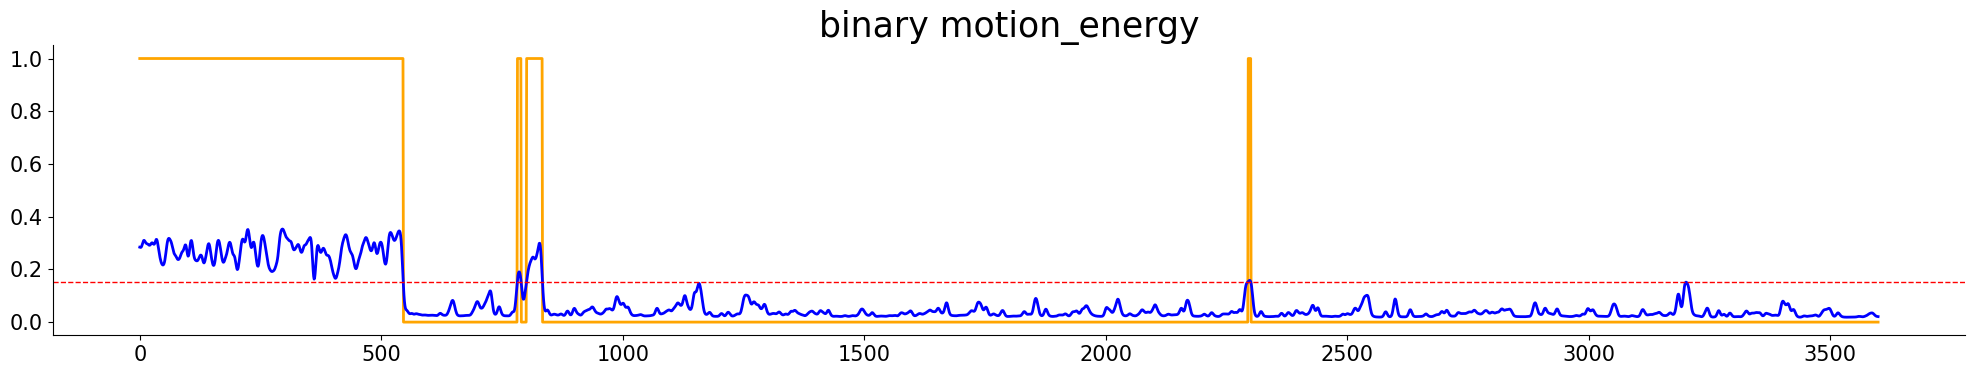

In [18]:
plt.plot(bin_motion_energy, color='orange', linewidth=2)
plt.plot(smoothed_motion_energy, color='blue', linewidth=2)
plt.title('binary motion_energy', fontsize=25)
plt.axhline(y=threshold_motion_otsu, color='red', linestyle='--', label='binary threshold', linewidth=1)
# plt.savefig(save_dir_videography + 'thresholded_binarised_motion_energy.png')
plt.show()

In [19]:
from scipy.signal import find_peaks

In [20]:
# # Compute first derivative
# diff_motion = np.gradient(motion_energy)

# # Find peaks in the derivative where slope is steep
# peaks, _ = find_peaks(diff_motion, height=some_slope_threshold)

In [21]:
from scipy.fft import fft
power = np.abs(fft(motion_energy[0:3600])) 

# Define onsets and offsets of active motion 

In [22]:
def get_onsets(bin_motion):
    onsets = np.where((bin_motion[1:] == 1) & (bin_motion[:-1] == 0))[0] + 1 #[0] specific to stcuture of array
    # if bin_motion[0] == 1:       
    return onsets
    
def get_offsets(bin_motion):
    offsets = np.where((bin_motion[1:] == 0) & (bin_motion[:-1] == 1))[0] + 1 #[0] specific to stcuture of array
    return offsets  

In [23]:
active_motion_onsets = get_onsets(bin_motion_energy)
active_motion_offsets = get_offsets(bin_motion_energy)

# Classify Active (awake) motions to short / long and visualise them

In [24]:
def classify_active_motion_segments(bin_motion_signal, motion_signal, short_threshold, long_threshold):
    """
    Classify active/awake motion segments into short (1–3 sec), long (>3 sec), and too short (<1 sec, those are exluded in awake motion detection and set to 0).

    Parameters:
    - bin_motion_signal: 1D array of HMM or thresholded motion states (1 for active, 0 for inactive)
    - motion_signal: 1D array of motion energy values
    - short_threshold: in frames, minimum duration for short active motions (e.g., 3 or 1s at 3Hz)
    - long_threshold: in frames, minimum duration for long active motions (e.g., 9 or 3s at 3Hz)

    Returns:
    - bin_short_active_motion: binary array marking short motions (1-3s)
    - bin_long_active_motion: binary array marking long motions (>3s)
    - bin_too_short_active_motion: binary array marking short blips (<1s)
    - and correspondings inds of long, short or too short (excluded) motions
    """
    labeled_array, num_features = label(bin_motion_signal == 1)

    bin_short_active_motion = np.zeros(len(motion_signal), dtype=int)
    bin_long_active_motion = np.zeros(len(motion_signal), dtype=int)
    bin_too_short_active_motion = np.zeros(len(motion_signal), dtype=int)

    for i in range(1, num_features + 1):
        segment = np.where(labeled_array == i)[0]

        if len(segment) > long_threshold:
            bin_long_active_motion[segment] = 1
        elif len(segment) > short_threshold:
            bin_short_active_motion[segment] = 1
        elif len(segment) > 0: # but shorter than short threshold 
            bin_too_short_active_motion[segment] = 0 # mark as inactive 

        long_active_motion_inds = np.where(bin_long_active_motion==1)[0]
        short_active_motion_inds = np.where(bin_short_active_motion==1)[0]
        too_short_active_motion_inds = np.where(bin_too_short_active_motion==1)[0]

            
    return bin_short_active_motion, short_active_motion_inds, bin_long_active_motion, long_active_motion_inds, bin_too_short_active_motion, too_short_active_motion_inds

Saved plot to: C:\Users\zaggila\Documents\pixelNMF\data\sz90_2024-06-06_a_cell_control\videography_processing\subplots_bin_motion_energy_classified.png


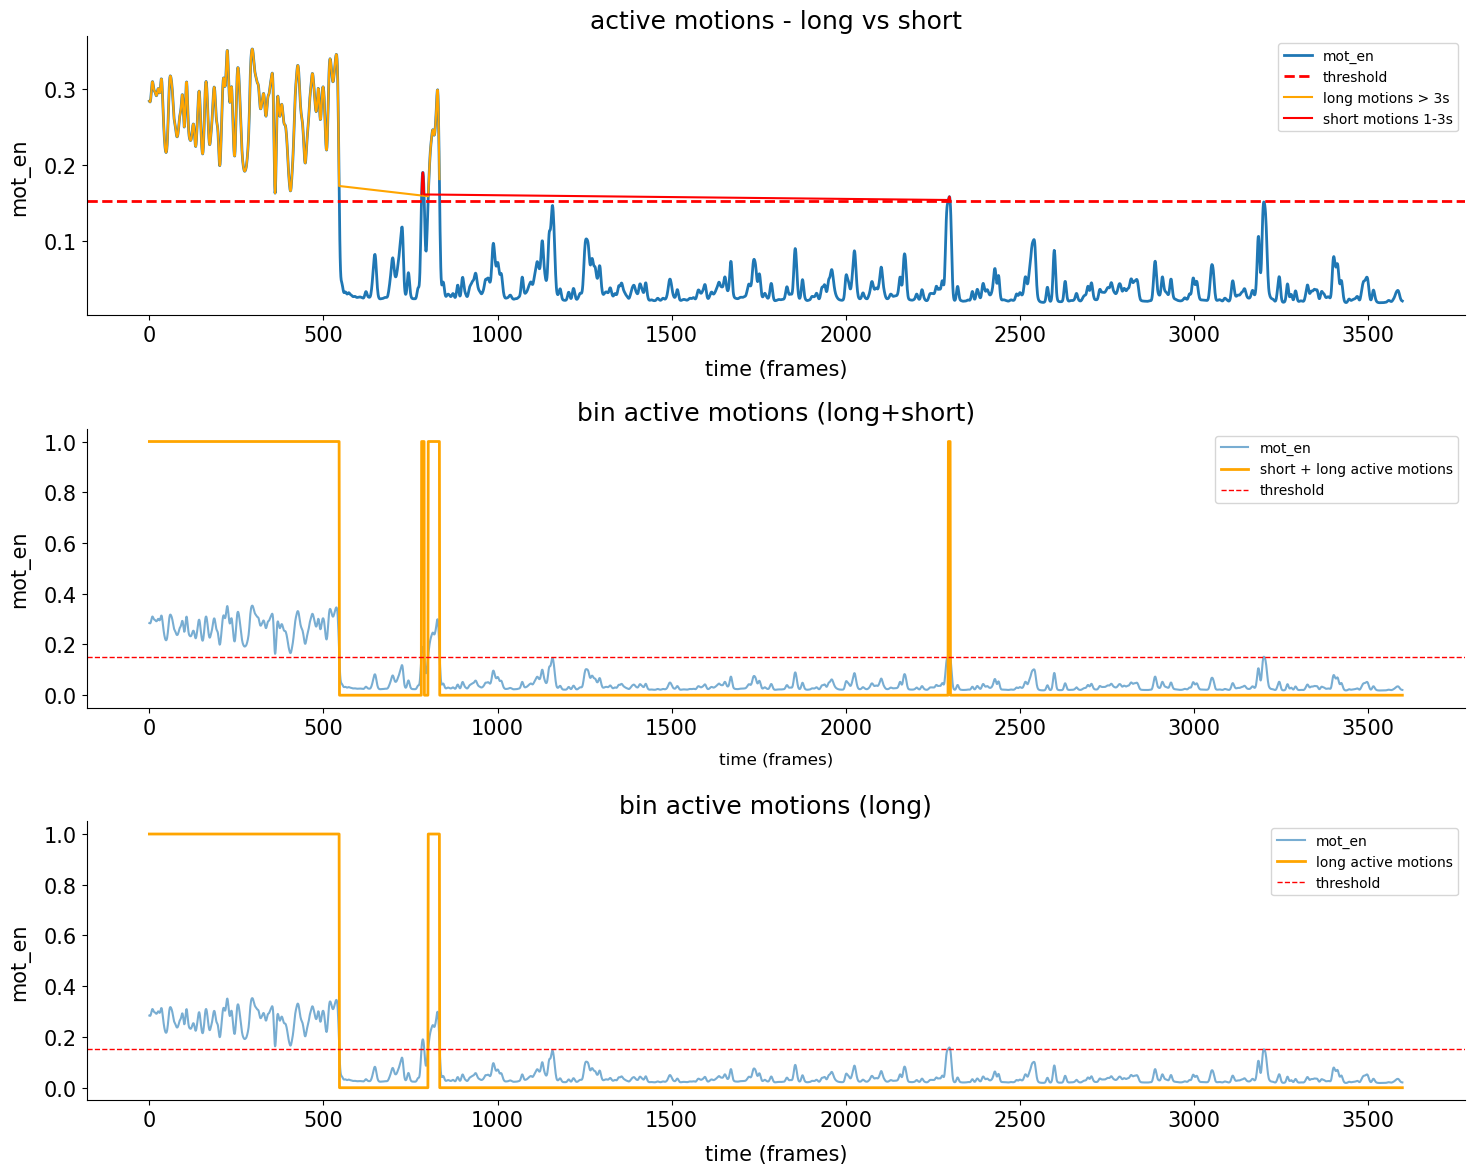

In [25]:
# classify active motions detected 
bin_short_active_motion, short_active_motion_inds, bin_long_active_motion, long_active_motion_inds, bin_too_short_active_motion, too_short_active_motion_inds = classify_active_motion_segments(
    bin_motion_energy,
    motion_energy,
    short_threshold=active_motion_duration_min,
    long_threshold=long_active_motion_duration_min
)

# plot classified active motions detected 
plot_active_motion_classification_subplots(
    motion_signal=motion_energy,
    smoothed_motion_signal=smoothed_motion_energy,
    bin_motion_energy=bin_motion_energy,
    bin_long_active_motion=bin_long_active_motion,
    bin_short_active_motion=bin_short_active_motion,
    long_active_motion_inds=long_active_motion_inds,
    short_active_motion_inds=short_active_motion_inds,
    threshold=threshold_motion_otsu,
    save_path=save_dir_videography / 'subplots_bin_motion_energy_classified.png',
)

In [26]:
# turn indices into continuous segments eg 25-100 is active seg 1, 500-805 active seg 2 etc
active_segments = get_active_segments(inds_active_state[0]) #all not only long
long_active_segments = get_active_segments(long_active_motion_inds) #all not only long , already numpy
# if len(short_active_segments)>1:
short_active_segments = get_active_segments(short_active_motion_inds)

# Twitch detection 

In [27]:
rest_period = motion_energy[inds_rest_state] #identify periods of low motion energy ==0 (non smoothed (!))
rest_period = rest_period.flatten()

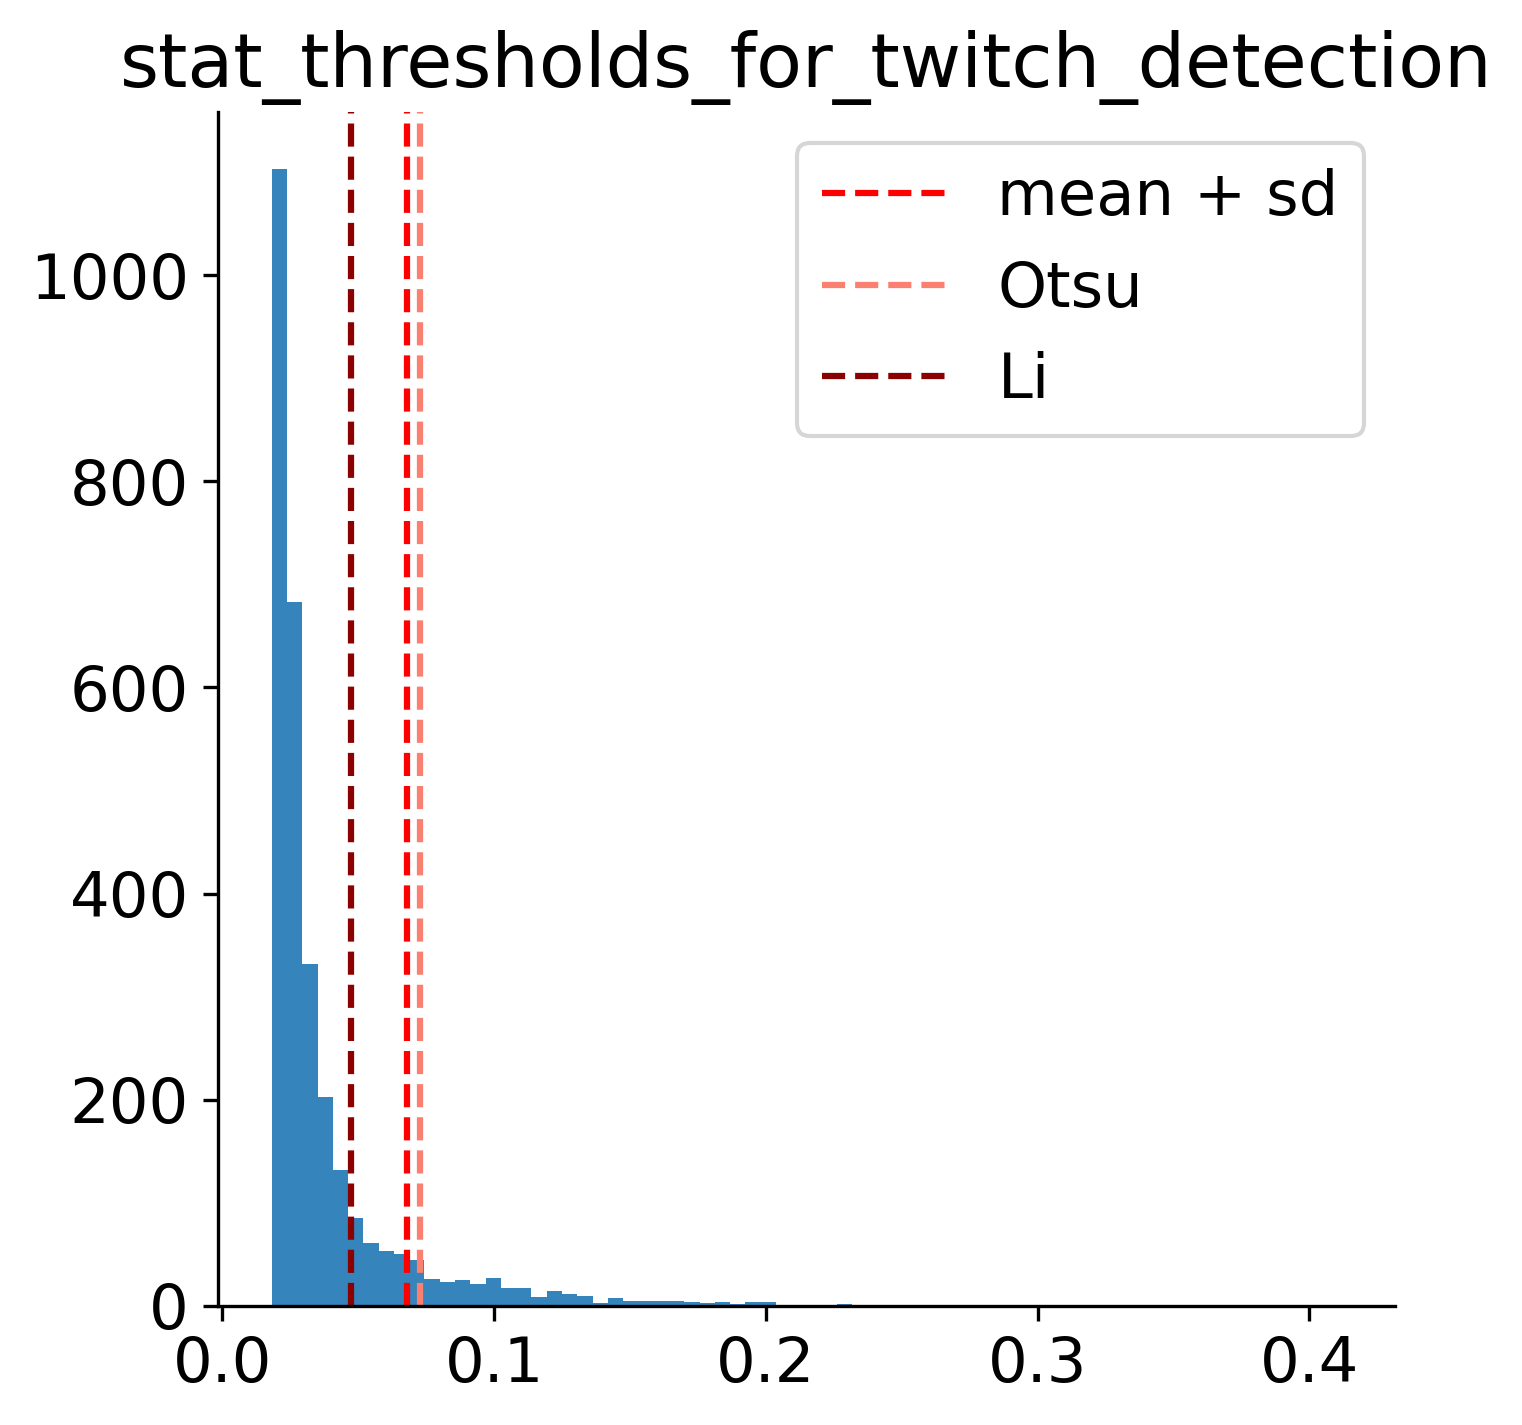

In [28]:
twitch_threshold_motion_mean_sd, twitch_threshold_motion_li, twitch_threshold_motion_otsu = compute_thresholds_for_bin_state_detection(rest_period, title='stat_thresholds_for_twitch_detection', save_dir=save_dir_videography, plot=True)

# Choose twitch threshold 

In [29]:
# choose a threshold 
twitch_threshold = twitch_threshold_motion_li #more permissive of twitches --> more twitches detected (pre-filtering)

In [30]:
inds_twitches_unfiltered = np.where(rest_period > twitch_threshold) #inds of prospective twitches (in array of low motion energy) careful its on the size of low motion array
inds_twitches_unfiltered = inds_rest_state[0][inds_twitches_unfiltered] 

In [31]:
unfiltered_putative_twitches_segments = find_sequential_groups(inds_twitches_unfiltered)
len(unfiltered_putative_twitches_segments)

215

In [32]:
def binarise_twitch(motion_energy, twitch_segments):

    # Initialize bin_twitch   
    bin_twitch = np.zeros(len(motion_energy))

    # flatten the nested list
    flat_inds = [idx for segment in twitch_segments for idx in segment] # filtered corrected twitch segments 

    print("Flattened Indices:", flat_inds)

    # Assign 1 to twitch inds
    for idx in flat_inds:
        if idx < len(motion_energy):  # Ensure index is within bounds
            bin_twitch[idx] = 1
            print(f"Assigning 1 at column {idx}")
        else:
            print(f"Skipping out-of-bounds index: {idx}")
    return bin_twitch

In [33]:
bin_putative_twitch = binarise_twitch(motion_energy, unfiltered_putative_twitches_segments) #segs 

Flattened Indices: [546, 553, 554, 563, 572, 622, 640, 642, 644, 645, 646, 647, 648, 649, 650, 651, 652, 653, 689, 692, 695, 696, 697, 698, 699, 700, 701, 702, 705, 707, 708, 710, 711, 712, 714, 715, 716, 717, 718, 719, 720, 721, 722, 723, 725, 726, 727, 728, 729, 743, 744, 745, 772, 781, 790, 791, 792, 794, 795, 796, 797, 798, 799, 800, 834, 835, 844, 845, 885, 886, 899, 900, 918, 923, 924, 928, 930, 936, 937, 939, 940, 941, 942, 965, 966, 971, 972, 974, 982, 984, 985, 986, 987, 988, 989, 990, 991, 992, 993, 994, 995, 996, 997, 999, 1000, 1001, 1002, 1003, 1004, 1008, 1009, 1011, 1012, 1013, 1070, 1071, 1072, 1089, 1094, 1097, 1098, 1104, 1105, 1107, 1109, 1110, 1111, 1112, 1113, 1114, 1115, 1116, 1117, 1118, 1119, 1120, 1122, 1125, 1126, 1127, 1128, 1129, 1130, 1131, 1132, 1134, 1135, 1136, 1141, 1146, 1147, 1148, 1149, 1150, 1151, 1152, 1153, 1154, 1155, 1156, 1157, 1158, 1159, 1160, 1161, 1162, 1163, 1164, 1165, 1180, 1204, 1217, 1248, 1249, 1250, 1251, 1252, 1253, 1254, 1255, 1256

# Filter twitches 


### Based on proximity to wake motions 

In [34]:
def filter_twitches_by_awake_proximity(inds_twitches, inds_active_state, min_distance=None):
    filtered_twitches = []

    for idx_twitch in inds_twitches:
        distance = np.abs(inds_active_state - idx_twitch)
        if np.min(distance) > min_distance:
            filtered_twitches.append(idx_twitch)

    filtered_twitches = np.array(filtered_twitches)

    return filtered_twitches

In [35]:
inds_twitches_filtered_step1 = filter_twitches_by_awake_proximity(inds_twitches_unfiltered, inds_active_state, min_distance=twitch_min_distance_from_active) 

### Based on duration 

In [36]:
inds_twitches_segments = find_sequential_groups(inds_twitches_filtered_step1)
active_motion_segments = find_sequential_groups(inds_active_state[0])
resting_motion_segments = find_sequential_groups(inds_rest_state[0])

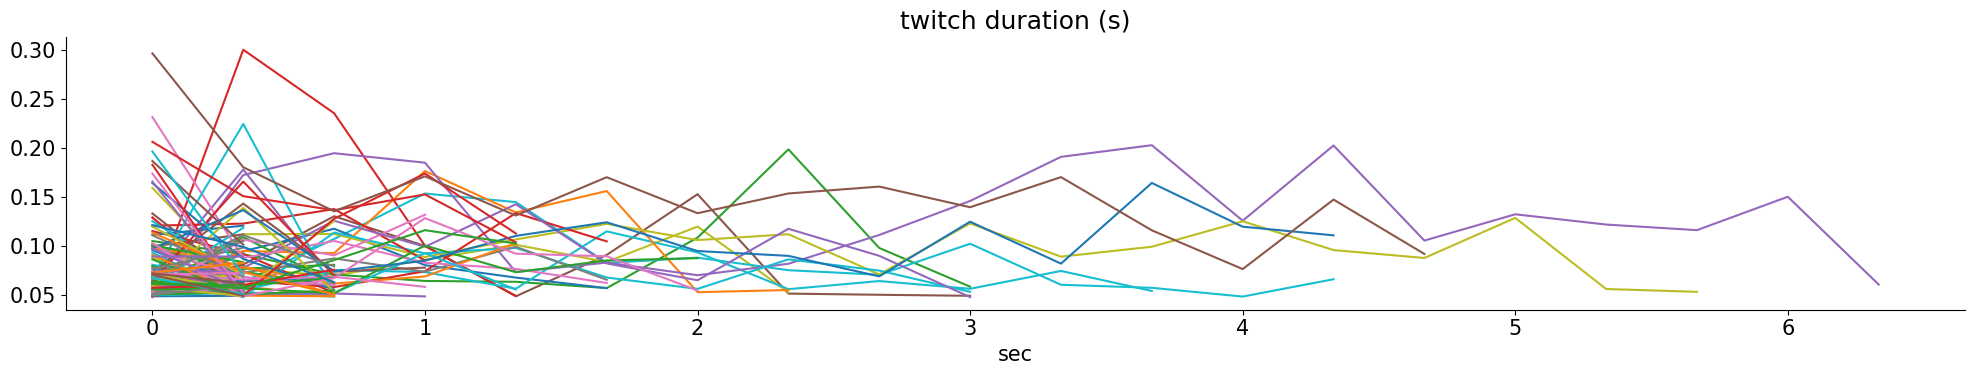

In [37]:
for seg in inds_twitches_segments:

    time = np.arange(len(seg))/framerate
    plt.plot(time, motion_energy[seg])
    plt.title('twitch duration (s)')
    plt.xlabel('sec')
plt.savefig(save_dir_videography / 'twitch_duration_non_filtered.png')

In [38]:
# filter twitches based on duration 
def filter_segments_by_duration(segments, duration_threshold):
# Filter out groups based on the duration threshold
    return [twitches for twitches in segments if len(twitches) <= duration_threshold]

In [39]:
# get filtered twitches 
inds_twitches_filtered_step2 = filter_segments_by_duration(inds_twitches_segments, twitch_duration_max)

# Binarise twitch 

In [40]:
def binarise_twitch(motion_energy, twitch_segments):

    # Initialize bin_twitch   
    bin_twitch = np.zeros(len(motion_energy))

    # flatten the nested list
    flat_inds = [idx for segment in twitch_segments for idx in segment] # filtered corrected twitches 

    print("Flattened Indices:", flat_inds)

    # Assign 1 to twitch inds
    for idx in flat_inds:
        if idx < len(motion_energy):  # Ensure index is within bounds
            bin_twitch[idx] = 1
            print(f"Assigning 1 at column {idx}")
        else:
            print(f"Skipping out-of-bounds index: {idx}")
    return bin_twitch

In [41]:
bin_twitch = binarise_twitch(motion_energy, inds_twitches_filtered_step2)

Flattened Indices: [563, 572, 622, 640, 642, 689, 692, 705, 707, 708, 710, 711, 712, 743, 744, 745, 772, 844, 845, 885, 886, 899, 900, 918, 923, 924, 928, 930, 936, 937, 965, 966, 971, 972, 974, 982, 1008, 1009, 1011, 1012, 1013, 1070, 1071, 1072, 1089, 1094, 1097, 1098, 1104, 1105, 1107, 1122, 1134, 1135, 1136, 1141, 1180, 1204, 1217, 1280, 1281, 1283, 1284, 1287, 1324, 1348, 1356, 1385, 1388, 1392, 1393, 1394, 1408, 1409, 1425, 1426, 1427, 1491, 1492, 1494, 1495, 1497, 1498, 1499, 1516, 1517, 1575, 1596, 1597, 1613, 1630, 1636, 1637, 1644, 1652, 1653, 1654, 1721, 1722, 1727, 1750, 1751, 1753, 1754, 1784, 1785, 1788, 1831, 1832, 1841, 1875, 1876, 1903, 1931, 1932, 1939, 1940, 1950, 1951, 1955, 1964, 1965, 2001, 2006, 2007, 2008, 2019, 2020, 2031, 2049, 2050, 2067, 2073, 2075, 2077, 2078, 2089, 2096, 2097, 2109, 2129, 2155, 2156, 2157, 2172, 2173, 2174, 2204, 2219, 2241, 2260, 2261, 2268, 2277, 2278, 2279, 2321, 2322, 2364, 2377, 2393, 2394, 2395, 2407, 2438, 2439, 2440, 2491, 2500, 25

# Filter twitches based on inter-twitch-interval (aka discard bursts, keep sparse 'trusted' twitches)

In [42]:
def remove_twitch_bursts(twitch_binary, framerate, min_interval=2):
    """
    Removes all twitches that occur within `min_interval` seconds of another twitch.
    Both twitches in a burst/close proximimity are excluded.
    
    Parameters:
        twitch_binary (np.ndarray): Binary vector of twitch detections (1 = twitch, 0 = no twitch)
        fs (float): framerate (Hz)
        min_interval (float): minimum interval required between twitches for those to be detected 
    
    Returns:
        np.ndarray: filtered binary twitch array 
    """
    twitch_indices = np.where(twitch_binary == 1)[0]
    to_remove = set()
    
    # Compare each twitch to the next one
    for i in range(len(twitch_indices) - 1):
        curr_idx = twitch_indices[i]
        next_idx = twitch_indices[i + 1]
        interval = (next_idx - curr_idx) / framerate
        
        if interval < min_interval:
            to_remove.add(curr_idx)
            to_remove.add(next_idx)
    
    filtered_twitches = np.copy(twitch_binary)
    filtered_twitches[list(to_remove)] = 0
    return filtered_twitches 

In [43]:
bin_twitch = remove_twitch_bursts(bin_twitch, framerate, min_interval=2)

# Define onset and offset of twitch

In [44]:
active_onsets = get_onsets(bin_motion_energy)
active_offsets = get_offsets(bin_motion_energy)
twitch_onsets = get_onsets(bin_twitch)
twitch_offsets = get_offsets(bin_twitch)

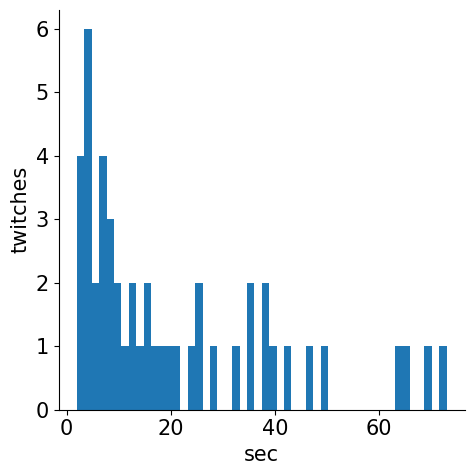

In [45]:
iti = np.diff(twitch_onsets/framerate)

plt.figure(figsize=(5,5))
plt.hist(iti.flatten(), bins=50)
plt.xlabel('sec')
plt.ylabel('twitches')
plt.show()

# Plot filtered twitches detected on motion energy

In [46]:
def plot_detected_twitches(
    motion_energy,
    smoothed_motion_energy,
    bin_motion_energy,
    threshold_twitches,
    threshold_motion_energy,
    inds_twitches,
    frame_ticks,
    second_ticks,
    save_dir_videography=None
):
    """
    Plot the motion energy and smoothed motion energy with twitch detection.

    Parameters:
    - motion_energy: Raw motion energy signal.
    - smoothed_motion_energy: Smoothed motion energy signal.
    - threshold_twitches: Threshold for twitch detection.
    - threshold_motion_energy: Threshold for binary motion energy.
    - inds_twitches: Indices where twitch segments start (onsets).
    - frame_ticks: Frame indices for x-axis.
    - second_ticks: Time ticks in seconds for x-axis.
    - save_dir_videography: Optional directory to save the figure.
    """
    
    fig, axs = plt.subplots(2, 1, figsize=(15, 7), dpi=300)

    # Plot raw and smoothed motion energy
    axs[0].plot(motion_energy, color='orange', linewidth=2, label='mot_en')
    axs[0].plot(smoothed_motion_energy, color='blue', linewidth=1.5, label='mot_en smoothed')
    axs[0].axhline(y=threshold_twitches, color='red', linestyle='--', label='Twitch threshold')
    axs[0].set_xticks(ticks=frame_ticks)
    axs[0].set_xticklabels(second_ticks, fontsize=12)
    axs[0].legend(loc='upper right', fontsize=10)
    axs[0].set_ylabel('mot_en', fontsize=15)
    axs[0].set_title('mot_en - twitch detection', fontsize=18)

    trio_motion_energy = bin_motion_energy.copy()
    trio_motion_energy[inds_twitches] = -1  # mark twitch segments with -1

    # Plot raw motion energy and binary motion energy (including twitch detection)
    axs[1].plot(motion_energy, color='blue', linewidth=1, label='mot_en')
    axs[1].plot(trio_motion_energy, color='darkorange', linewidth=1, label='3 states on mot_en')
    axs[1].axhline(y=threshold_twitches, color='red', linestyle='--', label='twitch threshold')
    axs[1].set_xticks(ticks=frame_ticks)
    axs[1].set_xticklabels(second_ticks, fontsize=12)
    axs[1].set_xlabel('Time (s)', fontsize=15)
    axs[1].set_title('Twitch Detection', fontsize=18)
    axs[1].legend(loc='upper right', fontsize=10)

    # Adjust layout and save the plot
    plt.subplots_adjust(hspace=0.6)

    if save_dir_videography:
        plt.savefig(save_dir_videography + 'trio_motion_energy_including_twitches.png')
        print(f"Plot saved to: {save_dir_videography + 'trio_motion_energy_including_twitches.png'}")

    plt.show()

Plot saved to: twitch_detectiontrio_motion_energy_including_twitches.png


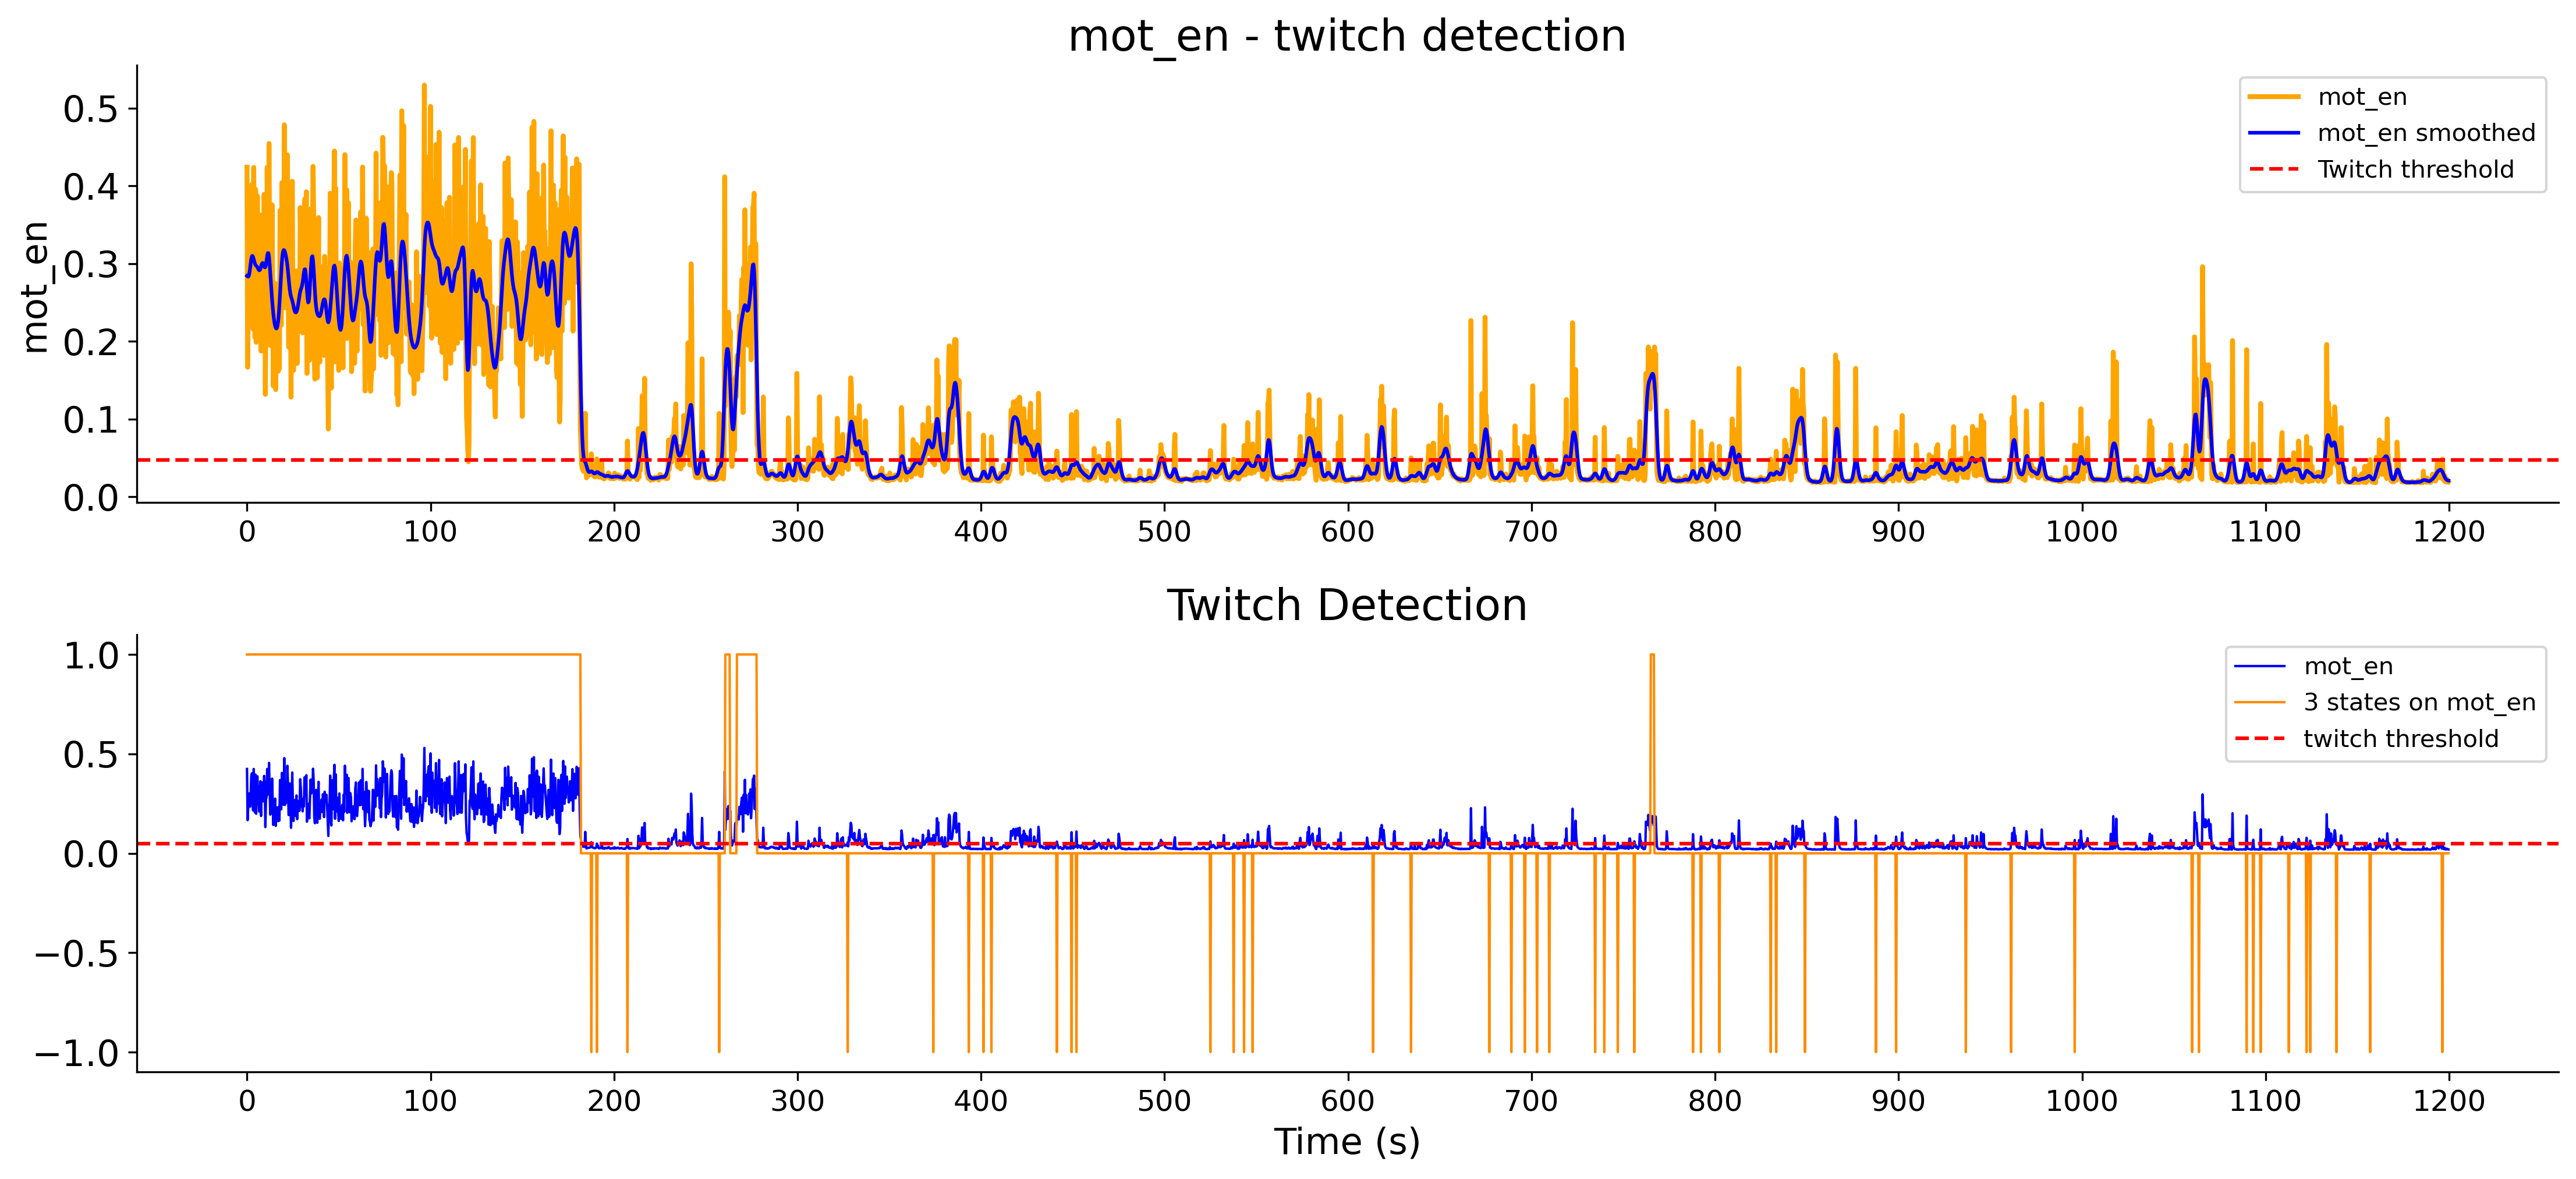

In [47]:
plot_detected_twitches(
    motion_energy=motion_energy,
    smoothed_motion_energy=smoothed_motion_energy,
    bin_motion_energy=bin_motion_energy,
    threshold_twitches=twitch_threshold,
    threshold_motion_energy= binary_threshold,
    inds_twitches=twitch_onsets,
    frame_ticks=frame_ticks,
    second_ticks=second_ticks,
    save_dir_videography='twitch_detection'
)

In [48]:
n_twitches = len(twitch_onsets) 
n_active_motions = len(active_motion_segments)

In [49]:
# ========== SUMMARY ==========
print(f"Total active/awake motions detected: {n_active_motions}")
print(f"Total twitches detected: {n_twitches}")

Total active/awake motions detected: 4
Total twitches detected: 49


# Final annotated motion 

In [87]:
def get_behavior_classification(bin_putative_twitch, bin_twitch, bin_motion_energy, active_onsets, twitch_onsets):
    """
    Classify behavior states and key motion onsets.

    Parameters:
        bin_putative_twitch (np.ndarray): raw unfiltered twitch binary array
        bin_twitch (np.ndarray): filtered twitch binary array
        bin_motion_energy (np.ndarray): binarized motion energy (1 = active, 0 = rest)

    Returns:
        dict: classified behavior array and key motion index groups
    """
    classified_behavior = bin_motion_energy.copy()
    classified_behavior[twitch_onsets] = -1
    classified_behavior[active_onsets] = 1

    # 2. Complex motion onsets (filtered twitches)
    complex_motion = (bin_putative_twitch == 1) & (bin_twitch == 0) # not-twitches 

    complex_onsets = np.where((complex_motion[1:]== 1) & (complex_motion[:-1]== 0))[0] +1
    complex_offsets = np.where((complex_motion[1:] ==0) & (complex_motion[:-1] ==1))[0] +1

    complex_motion_segments = []
    for onset,offset in zip(complex_onsets, complex_offsets):
        complex_motion_segments.append((onset,offset))
        classified_behavior[onset:offset] =2 

    # Index groups
    active_and_complex_motions = np.where((classified_behavior == 1) | (classified_behavior == 2))[0]
    only_active_motions = np.where(classified_behavior == 1)[0]
    twitch_onsets = np.where(classified_behavior == -1)[0]

    return classified_behavior, active_and_complex_motions, only_active_motions, complex_motion_segments ,complex_onsets, complex_offsets

In [88]:
classified_behavior, active_and_complex_motions, only_active_motions, complex_motion_segments, complex_onsets, complex_offsets  = get_behavior_classification(bin_putative_twitch, bin_twitch, bin_motion_energy, active_onsets, twitch_onsets)

In [74]:
import matplotlib.patches as mpatches 

def plot_classified_behavior_timeline(classified_behavior, motion_signal, framerate=3, title='Classified behavior', save_dir=None):
    """
    Plots the classified behavior as a color-coded horizontal bar with motion signal and segment durations.

    Parameters:
        classified_behavior (np.ndarray): array of -1, 0, 1, 2 values (behavior states)
        motion_signal (np.ndarray): array of raw or smoothed motion energy signal
        framerate (int): sampling frequency (for time axis), default is 3 Hz
        title (str): plot title
    """
    # Create a colormap for behavior classification
    color_map = {
        -1: 'red',  # Twitch onset - red
         0: 'grey',  # Rest - gray
         1: 'blue',  # Active - blue
         2: 'cyan'   # Complex motion - orange
    }

    # Time axis (in seconds)
    time = np.arange(len(classified_behavior)) / framerate

    # Normalize the motion signal
    motion_signal_norm = (motion_signal - np.min(motion_signal)) / (np.max(motion_signal) - np.min(motion_signal))

    # Create a figure for the plot
    plt.figure(figsize=(30, 5), dpi=300)

    # Initialize start index for segment tracking
    start_idx = 0
    
    # Plot each segment with color reflecting its duration
    for i in range(1, len(classified_behavior)):
        if classified_behavior[i] != classified_behavior[start_idx]:
            # Calculate the duration of the current segment
            segment_duration = (i - start_idx) / framerate
            
            # Adjust transparency based on segment duration (longer = less transparent)
            alpha_value = 0.5
            #= min(1, segment_duration / 10)  # Duration scaled to transparency (max duration = 10s)
            
            # Ensure red (Twitch) is not too transparent
            if classified_behavior[start_idx] == -1:
                alpha_value = max(0.95, alpha_value)  # Set a baseline for red to be visible even for short durations
            elif classified_behavior[start_idx] == 1:
                alpha_value = max(0.3, alpha_value)
            elif classified_behavior[start_idx] == 2:
                alpha_value = max(0.5, alpha_value)  #   
    
            # Plot the segment with the corresponding color and adjusted alpha
            plt.bar(time[start_idx:i], np.ones(i - start_idx), color=color_map[classified_behavior[start_idx]], 
                    width=1/framerate, align='edge', alpha=alpha_value, linewidth=15)
            
            start_idx = i  # Update start index for the next segment

    # Plot motion signal on top
    plt.plot(time, motion_signal_norm, color='blue', linewidth=1)

    # Add labels and title
    plt.xlabel('Time (s)', fontsize=25)
    plt.ylabel('motion_energy', fontsize=25)
    plt.yticks([])
    plt.title(title, fontsize=35)

    # Legend
    legend_patches = [
        mpatches.Patch(color=color_map[-1], label='Twitch (-1)'),
        mpatches.Patch(color=color_map[0], label='Rest (0)'),
        mpatches.Patch(color=color_map[1], label='Active (1)'),
        mpatches.Patch(color=color_map[2], label='Complex (2)'),
    ]
    plt.legend(handles=legend_patches, loc='upper right', fontsize=15)

    plt.savefig(save_dir / 'classified_behavior.png')
    plt.tight_layout()
    plt.show()

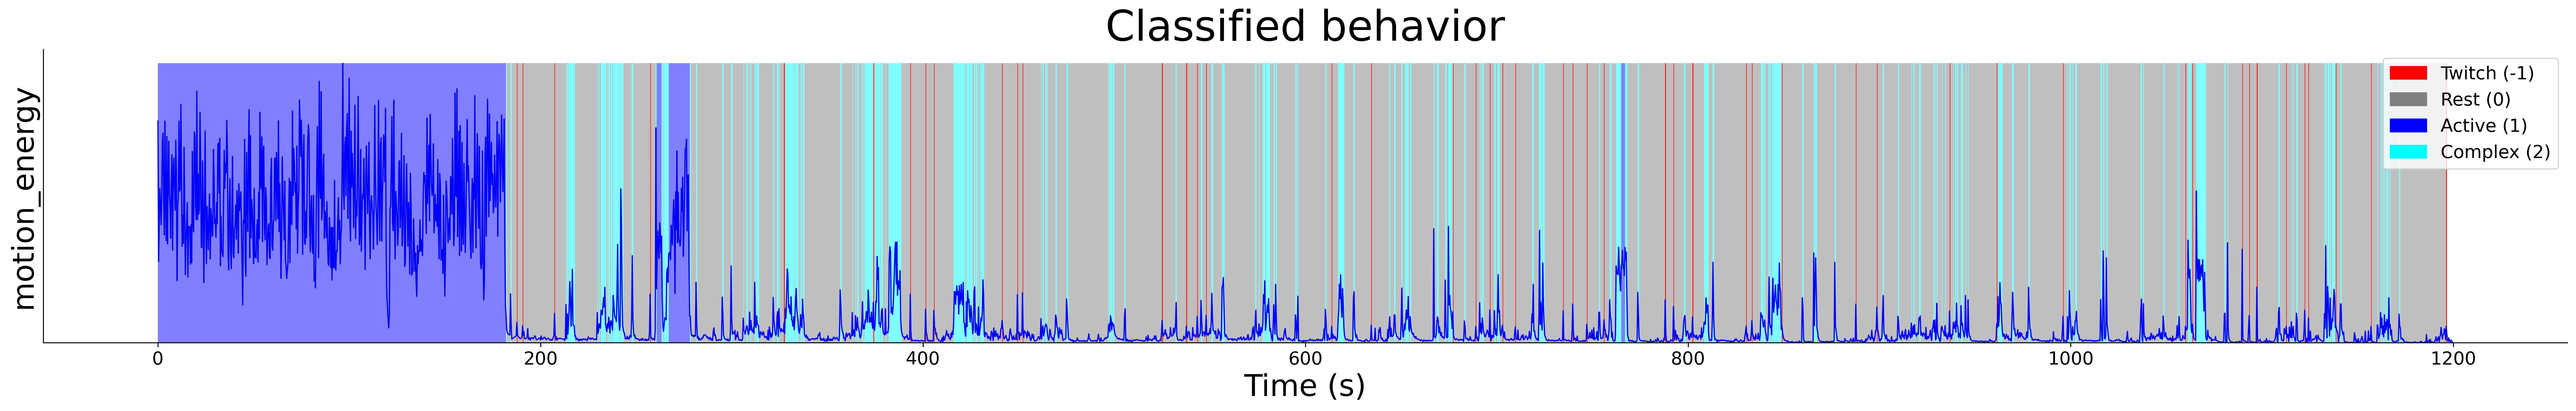

In [75]:
plot_classified_behavior_timeline(classified_behavior, motion_energy, framerate=3, save_dir=save_dir_videography)

# Save all outputs 

In [76]:
classified_behavior, active_and_complex_motions, only_active_motions, complex_motion_segments, complex_onsets, complex_offsets
auto_detection = {
    'frequency' : framerate,
    # 'binary_threshold' : 'otsu',
    # 'twitch_threshold' : 'li',
    '+- active_motion_min_distance' : twitch_min_distance_from_active/framerate , #sec
    'motion_energy_downsampled_2x' : motion_energy,
    'binary_motion_energy' : bin_motion_energy,

    'classified_behavior': classified_behavior, # np.array: classified behavior (pre-curation): 0,1,-1,2 aka Rest, Active, Twitch, Complex
    
    'active_motion_onsets' : active_motion_onsets,
    'active_motion_offsets' : active_motion_offsets,
    'active_motion_segments' : active_motion_segments,

    'active_and_complex_motions':active_and_complex_motions,
    'only_active_motions':only_active_motions,

    'complex_onsets': complex_onsets,
    'complex_offsets': complex_onsets,
    'complex_motion_segments' : complex_motion_segments, #just (onset,offset)

    'binary_twich':bin_twitch, #binary array where 1 == twitch 
    'inds_twitches_segments': inds_twitches_segments,
    'n_twitches' : n_twitches, # no. of twitches 
    'twitch_onsets': twitch_onsets,  # onsets 
    'twitch_offsets': twitch_offsets  # offsets     
}

np.save(save_dir + f'auto_detection_{ds}.npy', auto_detection)
# np.savez(save_dir + f"auto_detection_{ds}.npz", **auto_detection) 

In [78]:
keys_to_excel = [
    'twitch_onsets',
    'twitch_offsets',
    'active_motion_onsets',
    'active_motion_offsets',
    'complex_onsets',
    'complex_offsets'
]
export_to_excel = {key:auto_detection[key] for key in keys_to_excel}

In [79]:
max_length = max(len(value) for value in export_to_excel.values()) 

# Pad arrays to the maximum length
for key, value in export_to_excel.items():
    # Cast integer arrays to float before padding
    if len(value) < max_length:
        export_to_excel[key] = np.pad(np.array(value, dtype=float), (0, max_length - len(value)), constant_values=np.nan)

# Now create the DataFrame
df = pd.DataFrame(export_to_excel)

# Export to Excel
output_path = os.path.join(save_dir_videography, 'beh_annoations.xls')
df.to_excel(output_path, index=False, engine='openpyxl')

In [80]:
save_dir_videography

WindowsPath('C:/Users/zaggila/Documents/pixelNMF/data/sz90_2024-06-06_a_cell_control/videography_processing')

# Write on video for validation (manual curation)

In [81]:
tiff = io.imread(movie_path, plugin='pil')

# making sure smallest value of tiff is zero - just a linear transform, shouldn't affect NMF ? 
tiff -= np.min(tiff)
print(f'Shape of video: {tiff.shape}')

C:\Users\zaggila\AppData\Local\Temp\ipykernel_19308\1961492092.py:1: FutureWarning: The plugin infrastructure in `skimage.io` and the parameter `plugin` are deprecated since version 0.25 and will be removed in 0.27 (or later). To avoid this warning, please do not use the parameter `plugin`. Instead, use `imageio` or other I/O packages directly. See also `imread`.
  tiff = io.imread(movie_path, plugin='pil')


Shape of video: (3600, 307, 880)


In [82]:
# Define onset points (from onset_twitch_1d)
for onset_time in twitch_onsets:
    # Ensure onset_time is within the frame count
    if onset_time < len(tiff):
        frame = tiff[onset_time]
        frame_bgr = cv2.cvtColor(frame, cv2.COLOR_GRAY2BGR)
        
        # write 'Twitch') at a fixed location (x, y)
        cv2.putText(frame_bgr, 'Twitch onset', (50, 100), cv2.FONT_HERSHEY_SIMPLEX, 1, (0,0,255), 1, cv2.LINE_AA)

        tiff[onset_time] = cv2.cvtColor(frame_bgr, cv2.COLOR_BGR2GRAY) 

        # tiff[onset_time] = cv2.cvtColor(frame_bgr, cv2.COLOR_BGR2GRAY)

        print("Finished marking onset frames.")

for active_mot_onset in active_motion_onsets: 
    if active_mot_onset < len(tiff):
        frame= tiff[active_mot_onset]
        frame_bgr = cv2.cvtColor(frame, cv2.COLOR_GRAY2BGR)
        cv2.putText(frame_bgr, 'Active motion onset', (50, 100), cv2.FONT_HERSHEY_SIMPLEX, 1, (0,0,255), 1, cv2.LINE_AA)
        tiff[active_mot_onset] = cv2.cvtColor(frame_bgr, cv2.COLOR_BGR2GRAY) 

for active_motion_offset in active_motion_offsets:
    if active_motion_offset < len(tiff):
        frame = tiff[active_motion_offset]
        frame_bgr = cv2.cvtColor(frame, cv2.COLOR_GRAY2BGR)
        cv2.putText(frame_bgr, 'Active motion offset', (50, 100), cv2.FONT_HERSHEY_SIMPLEX, 1, (0,0,255), 1, cv2.LINE_AA)
        tiff[active_motion_offset] = cv2.cvtColor(frame_bgr, cv2.COLOR_BGR2GRAY)   

for complex_motion_onset in complex_onsets:
    if complex_motion_onset < len(tiff):
        frame=tiff[complex_motion_onset]
        frame_bgr = cv2.cvtColor(frame, cv2.COLOR_GRAY2BGR)
        cv2.putText(frame_bgr, 'Complex motion', (50,100), cv2.FONT_HERSHEY_SIMPLEX, 1, (0,0,255), 1, cv2.LINE_AA)
        tiff[complex_motion_onset] = cv2.cvtColor(frame_bgr, cv2.COLOR_BGR2GRAY)
    

Finished marking onset frames.
Finished marking onset frames.
Finished marking onset frames.
Finished marking onset frames.
Finished marking onset frames.
Finished marking onset frames.
Finished marking onset frames.
Finished marking onset frames.
Finished marking onset frames.
Finished marking onset frames.
Finished marking onset frames.
Finished marking onset frames.
Finished marking onset frames.
Finished marking onset frames.
Finished marking onset frames.
Finished marking onset frames.
Finished marking onset frames.
Finished marking onset frames.
Finished marking onset frames.
Finished marking onset frames.
Finished marking onset frames.
Finished marking onset frames.
Finished marking onset frames.
Finished marking onset frames.
Finished marking onset frames.
Finished marking onset frames.
Finished marking onset frames.
Finished marking onset frames.
Finished marking onset frames.
Finished marking onset frames.
Finished marking onset frames.
Finished marking onset frames.
Finished

In [83]:
active_motion_onsets

array([ 782,  801, 2295], dtype=int64)

In [84]:
save_dir_videography

WindowsPath('C:/Users/zaggila/Documents/pixelNMF/data/sz90_2024-06-06_a_cell_control/videography_processing')

In [85]:
len(twitch_onsets)

49

In [86]:
output_dir = save_dir_videography / '_validation_twitch_video.tif'
# Export the marked frames as TIFF sequence
os.makedirs(output_dir, exist_ok=True)

# Save frames as TIFF files
for i, frame in enumerate(tiff):
    output_path = os.path.join(output_dir, f"frame_{i:04d}.tiff")
    img = Image.fromarray(frame)
    img.save(output_path)
    

print(f"Exported {len(tiff)} frames to {output_dir}")

Exported 3600 frames to C:\Users\zaggila\Documents\pixelNMF\data\sz90_2024-06-06_a_cell_control\videography_processing\_validation_twitch_video.tif
